# Prédictions de revenus à partir de statistiques US

On veut prédire le niveau de revenus (supérieur à 50k$ ou non) à partir de données du bureau de statistiques US. 

On peut trouver le dataset sur :  
https://www.kaggle.com/uciml/adult-census-income  
https://archive.ics.uci.edu/ml/datasets/census+income  

Les caractéristiques sont :  
- Income: >50K, <=50K
- age: en années
- workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
- fnlwgt: "poids" (donnée statistique par rapport aux populations)
- education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool
- education-num: continuous
- marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse
- occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces
- relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
- race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
- sex: Female, Male
- capital-gain: gains liés aux investissements
- capital-loss: pertes liées aux investissements
- hours-per-week: continuous
- native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands

## Librairies et fonctions utiles

In [7]:
# Directive pour afficher les graphiques dans Jupyter
%matplotlib inline

In [8]:
# Pandas : librairie de manipulation de données
# NumPy : librairie de calcul scientifique
# MatPlotLib : librairie de visualisation et graphiques
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from IPython.core.display import HTML # permet d'afficher du code html dans jupyter

Fonction pour standardiser les données quantitatives (cont_feat est une liste des colonnes correspondant à des caractéristiques quantitatives) :

In [9]:
def scale_feat(df,cont_feat) :
    df1=df
    scaler = preprocessing.RobustScaler()
    df1[cont_feat] = scaler.fit_transform(df1[cont_feat])
    scaler = preprocessing.StandardScaler()
    df1[cont_feat] = scaler.fit_transform(df1[cont_feat]) 
    return df1

Fonction pour tracer les courbes d'apprentissage sur l'ensemble d'apprentissage et l'ensemble de validation :

In [10]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(est, X_train, y_train) :
    train_sizes, train_scores, test_scores = learning_curve(estimator=rf, X=X_train, y=y_train, train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(8,10))
    plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
    plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='validation accuracy')
    plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')
    plt.grid(b='on')
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.6, 1.0])
    plt.show()

Fonction pour tracer la courbe ROC :

In [11]:
def plot_roc_curve(est,X_test,y_test) :
    probas = est.predict_proba(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,probas[:, 1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')        # plus mauvaise courbe
    plt.plot([0,0,1],[0,1,1],'g:')     # meilleure courbe
    plt.xlim([-0.05,1.2])
    plt.ylim([-0.05,1.2])
    plt.ylabel('Taux de vrais positifs')
    plt.xlabel('Taux de faux positifs')
    plt.show

Fonction pour équilibrer un dataframe *df* sur la colonne cible *target_col* avec la classe minoritaire *minority_class* :

In [12]:
def undersample(df, target_col, minority_class) :
    df_minority = df[df[target_col] == minority_class]
    df_majority = df.drop(df_minority.index)
    ratio=len(df_minority)/len(df_majority)
    df_majority = df_majority.sample(frac=ratio)
    df1 = pd.concat((df_majority,df_minority), axis=0)
    return df1.sample(frac=1)

## Traitement du dataset

In [13]:
df = pd.read_csv("Dataset.data", header=None, delimiter="\s+")
df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"] #attribut des noms aux colonnes

In [14]:
df.tail(10)

Age     WorkClass  fnlwgt  Education  EducationNum       MaritalStatus  \
8520   30  Self-emp-inc  132601  Bachelors            13  Married-civ-spouse   
8521   27       Private  357348    HS-grad             9       Never-married   
8522   22       Private  150683    HS-grad             9       Never-married   
8523   40  Self-emp-inc  188615       11th             7  Married-civ-spouse   
8524   73       Private  159007  Bachelors            13            Divorced   
8525   23       Private  130959  Bachelors            13  Married-civ-spouse   
8526   51       Private  158746  Bachelors            13  Married-civ-spouse   
8527   29       Private  498833    HS-grad             9  Married-civ-spouse   
8528   46       Private  193188    Masters            14       Never-married   
8529   29  Self-emp-inc  136277    HS-grad             9                 NaN   

            Occupation    Relationship   Race  Gender  CapitalGain  \
8520      Craft-repair         Husband  White    Male          0.0   
8521      Adm-clerical   Not-in-family  White  Female       2202.0   
8522  Transport-moving       Own-child  White    Male          0.0   
8523   Exec-managerial         Husband  White    Male      15024.0   
8524   Farming-fishing  Other-relative  White  Female          0.0   
8525    Prof-specialty         Husband  White    Male       2407.0   
8526   Exec-managerial         Husband  White    Male          0.0   
8527      Adm-clerical            Wife  White  Female          0.0   
8528   Exec-managerial       Unmarried  White    Male          0.0   
8529               NaN             NaN    NaN     NaN          NaN   

      CapitalLoss  HoursPerWeek  NativeCountry Income  
8520          0.0          40.0  United-States   >50K  
8521          0.0          40.0  United-States  <=50K  
8522          0.0          20.0  United-States  <=50K  
8523          0.0          20.0  United-States   >50K  
8524          0.0          12.0  United-States  <=50K  
8525          0.0           6.0         Canada  <=50K  
8526       1902.0          60.0  United-States   >50K  
8527          0.0          40.0      Nicaragua  <=50K  
8528          0.0          40.0  United-States  <=50K  
8529          NaN           NaN            NaN    NaN

In [15]:
df.count()

Age              8530
WorkClass        8530
fnlwgt           8530
Education        8530
EducationNum     8530
MaritalStatus    8529
Occupation       8529
Relationship     8529
Race             8529
Gender           8529
CapitalGain      8529
CapitalLoss      8529
HoursPerWeek     8529
NativeCountry    8529
Income           8529
dtype: int64

On mappe les valeurs de la colonne cible en 0/1 :

In [16]:
df["Income"] = df["Income"].map({ "<=50K": 0, ">50K": 1 })#un transforme <=50K en 0 >50K en 1 dans la datasette

In [17]:
cont_feat = ["Age", "fnlwgt", "EducationNum", "HoursPerWeek","CapitalGain","CapitalLoss"]#grandeurs continu
discr_feat = ["WorkClass", "Education", "MaritalStatus", "Occupation", "Relationship", 
              "Race", "Gender", "NativeCountry"]#grandeures discretes ex: oui, non, 0,1,2...

On convertit les catégories en étiquettes numériques :

In [18]:
for col in discr_feat :
    df[col]=df[col].astype('category')#
    df[col] = df[col].cat.codes#attribut des numéros
    df[col]=df[col].astype('int8')#convertir tous champ en entier
    

In [19]:
df.head()

Age  WorkClass  fnlwgt  Education  EducationNum  MaritalStatus  Occupation  \
0   25          3  226802          1             7              4           7   
1   38          3   89814         11             9              2           5   
2   28          2  336951          7            12              2          11   
3   44          3  160323         15            10              2           7   
4   18          0  103497         15            10              4           0   

   Relationship  Race  Gender  CapitalGain  CapitalLoss  HoursPerWeek  \
0             3     2       1          0.0          0.0          40.0   
1             0     4       1          0.0          0.0          50.0   
2             0     4       1          0.0          0.0          40.0   
3             0     2       1       7688.0          0.0          40.0   
4             3     4       0          0.0          0.0          30.0   

   NativeCountry  Income  
0             38     0.0  
1             38     0.0  
2             38     1.0  
3             38     1.0  
4             38     0.0

On vérifie s'il y a des valeurs indéterminées dans le dataset :

In [20]:
df.isnull().values.sum()

4

On complète ces valeurs :

In [21]:
df = df.fillna(method='pad')

In [22]:
df.isnull().values.any()

False

Les valeurs numériques ont des caractéristiques très différentes :

In [23]:
df[cont_feat].describe()

Age        fnlwgt  EducationNum  HoursPerWeek   CapitalGain  \
count  8530.000000  8.530000e+03   8530.000000   8530.000000   8530.000000   
mean     38.693552  1.882292e+05     10.060492     40.435991   1128.853810   
std      13.803450  1.051589e+05      2.574321     12.428987   7903.255739   
min      17.000000  1.376900e+04      1.000000      1.000000      0.000000   
25%      28.000000  1.156770e+05      9.000000     40.000000      0.000000   
50%      37.000000  1.779815e+05     10.000000     40.000000      0.000000   
75%      48.000000  2.374818e+05     12.000000     45.000000      0.000000   
max      90.000000  1.490400e+06     16.000000     99.000000  99999.000000   

       CapitalLoss  
count  8530.000000  
mean     87.241618  
std     401.946784  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max    3175.000000

On normalise ces valeurs :

In [24]:
df=scale_feat(df,cont_feat)

In [25]:
df[cont_feat].describe()

Age        fnlwgt  EducationNum  HoursPerWeek   CapitalGain  \
count  8.530000e+03  8.530000e+03  8.530000e+03  8.530000e+03  8.530000e+03   
mean  -1.999182e-17 -1.749285e-17 -1.374438e-17 -7.080438e-18 -1.551449e-17   
std    1.000059e+00  1.000059e+00  1.000059e+00  1.000059e+00  1.000059e+00   
min   -1.571696e+00 -1.659113e+00 -3.519772e+00 -3.173091e+00 -1.428424e-01   
25%   -7.747468e-01 -6.899704e-01 -4.119745e-01 -3.508059e-02 -1.428424e-01   
50%   -1.226977e-01 -9.745581e-02 -2.349976e-02 -3.508059e-02 -1.428424e-01   
75%    6.742513e-01  4.683904e-01  7.534496e-01  3.672284e-01 -1.428424e-01   
max    3.717147e+00  1.238362e+01  2.307348e+00  4.712165e+00  1.251079e+01   

        CapitalLoss  
count  8.530000e+03  
mean   2.707226e-17  
std    1.000059e+00  
min   -2.170604e-01  
25%   -2.170604e-01  
50%   -2.170604e-01  
75%   -2.170604e-01  
max    7.682458e+00

Il y a beaucoup moins de revenus >50$ :

In [26]:
df.Income.value_counts()

0.0    6536
1.0    1994
Name: Income, dtype: int64

On va rééquilibrer le dataset en sous-échantillonant aléatoirement la classe majoritaire :

In [27]:
df = undersample(df, 'Income', 1)
print(df.Income.value_counts())

0.0    1994
1.0    1994
Name: Income, dtype: int64


## Constitution des jeux d'apprentissage et de test

In [28]:
X = df.drop(['Income'], axis=1)
y = df.Income

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

## Machine learning

### Forêts aléatoires

On teste les forêts aléatoires :

In [30]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier()
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [31]:
print(classification_report(y_test, y_rf))

              precision    recall  f1-score   support

         0.0       0.80      0.79      0.80      1009
         1.0       0.79      0.79      0.79       985

   micro avg       0.79      0.79      0.79      1994
   macro avg       0.79      0.79      0.79      1994
weighted avg       0.79      0.79      0.79      1994



In [32]:
cm = confusion_matrix(y_test, y_rf)
print(cm)

[[801 208]
 [204 781]]


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


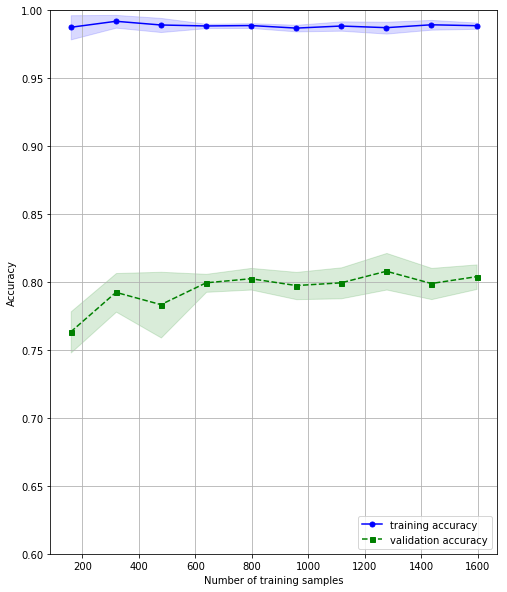

In [33]:
plot_learning_curve(rf, X_train, y_train)

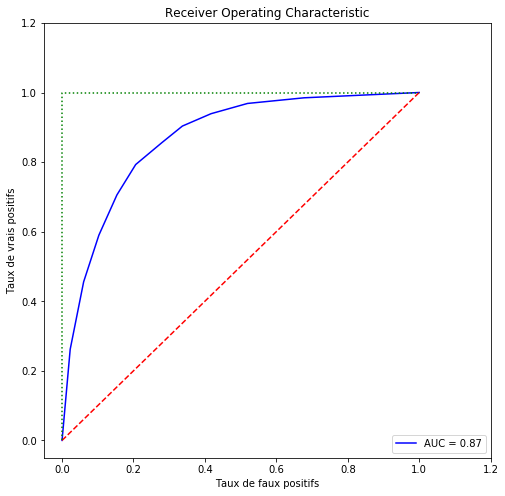

In [34]:
plot_roc_curve(rf,X_test,y_test)

### Gradient boosting

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()#
gb.fit(X_train,y_train)
y_gb = gb.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_gb)
print(cm)
gb_score = metrics.accuracy_score(y_test, y_gb)
print(gb_score)
print(classification_report(y_test, y_gb))

[[784 225]
 [139 846]]
0.8174523570712137
              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81      1009
         1.0       0.79      0.86      0.82       985

   micro avg       0.82      0.82      0.82      1994
   macro avg       0.82      0.82      0.82      1994
weighted avg       0.82      0.82      0.82      1994



c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


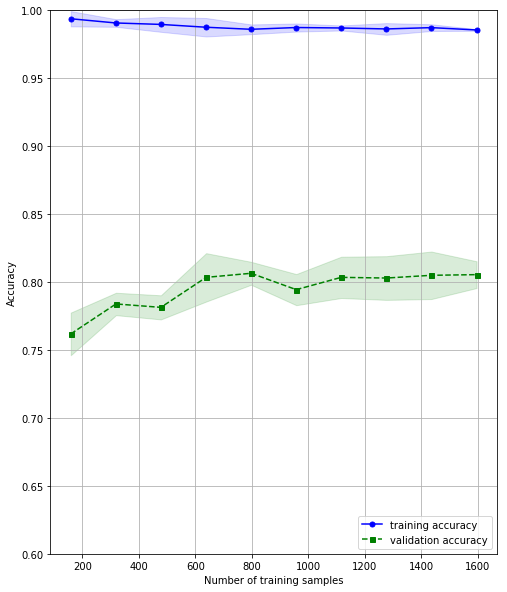

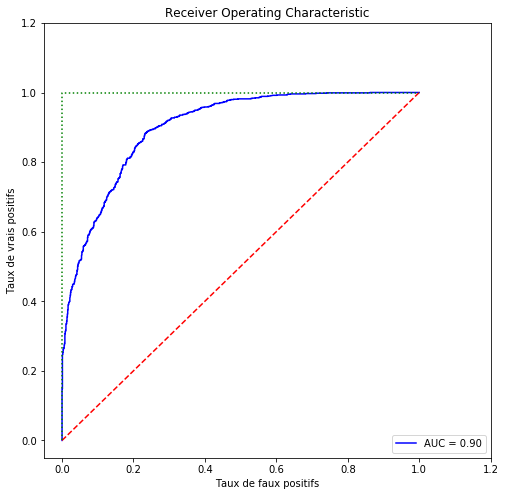

In [36]:
plot_learning_curve(gb, X_train, y_train)
plot_roc_curve(gb,X_test,y_test)

### Catboost

In [37]:
i_discrete = [df.columns.get_loc(c) for c in df.columns if c not in cont_feat]
print(i_discrete)

[1, 3, 5, 6, 7, 8, 9, 13, 14]


In [38]:
i_discrete = [1, 3, 5, 6, 7, 8, 9]

In [39]:
df.describe()

Age    WorkClass       fnlwgt    Education  EducationNum  \
count  3988.000000  3988.000000  3988.000000  3988.000000   3988.000000   
mean      0.149335     3.096790     0.013468    10.447091      0.199863   
std       0.948183     1.183517     1.015670     3.553096      1.017213   
min      -1.571696     0.000000    -1.659113     0.000000     -3.519772   
25%      -0.557397     3.000000    -0.684088     9.000000     -0.411974   
50%       0.094652     3.000000    -0.096044    11.000000     -0.023500   
75%       0.819151     3.000000     0.478728    12.000000      1.141924   
max       3.717147     7.000000     8.174710    15.000000      2.307348   

       MaritalStatus   Occupation  Relationship         Race       Gender  \
count    3988.000000  3988.000000   3988.000000  3988.000000  3988.000000   
mean        2.450100     6.745486      1.195838     3.710632     0.725176   
std         1.344672     4.142334      1.624836     0.799120     0.446482   
min         0.000000     0.000000      0.000000     0.000000     0.000000   
25%         2.000000     3.000000      0.000000     4.000000     0.000000   
50%         2.000000     7.000000      0.000000     4.000000     1.000000   
75%         4.000000    10.000000      2.000000     4.000000     1.000000   
max         6.000000    14.000000      5.000000     4.000000     1.000000   

       CapitalGain  CapitalLoss  HoursPerWeek  NativeCountry       Income  
count  3988.000000  3988.000000   3988.000000    3988.000000  3988.000000  
mean      0.137335     0.092556      0.133046      35.971163     0.500000  
std       1.442453     1.200434      0.975642       7.338286     0.500063  
min      -0.142842    -0.217060     -3.173091       0.000000     0.000000  
25%      -0.142842    -0.217060     -0.035081      38.000000     0.000000  
50%      -0.142842    -0.217060     -0.035081      38.000000     0.500000  
75%      -0.142842    -0.217060      0.769537      38.000000     1.000000  
max      12.510786     7.682458      4.712165      40.000000     1.000000

In [41]:
from catboost import CatBoostClassifier
cb = CatBoostClassifier(iterations=10000, depth=3, learning_rate=0.1)
cb.fit(X_train, y_train, i_discrete, eval_set=(X_test, y_test), silent=True)
y_cb = cb.predict(X_test)
print(cb.score(X_test,y_test))

0.8184553660982948


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


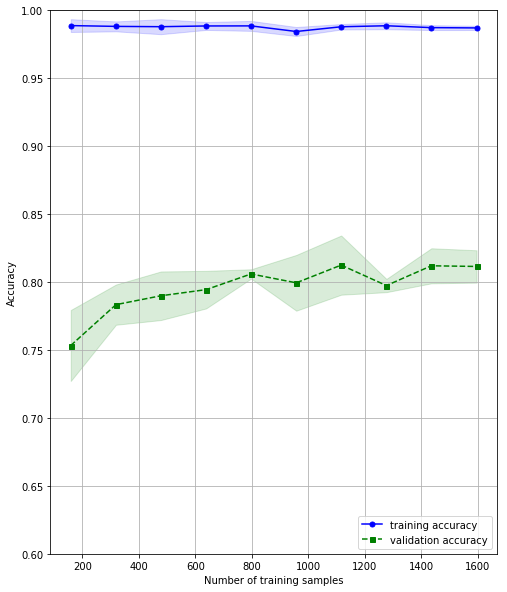

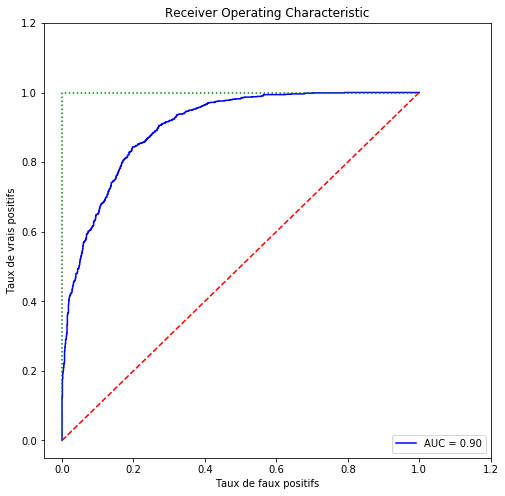

In [42]:
plot_learning_curve(cb, X_train, y_train)
plot_roc_curve(cb,X_test,y_test)

In [43]:
print(classification_report(y_test, y_cb))

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81      1009
         1.0       0.80      0.85      0.82       985

   micro avg       0.82      0.82      0.82      1994
   macro avg       0.82      0.82      0.82      1994
weighted avg       0.82      0.82      0.82      1994



### XGBoost

In [44]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
print(xgb.score(X_test,y_test))

0.820962888665998


In [45]:
y_xgb = xgb.predict(X_test)
cm = metrics.confusion_matrix(y_test, y_xgb)
print(cm)
xgb_score = metrics.accuracy_score(y_test, y_xgb)
print(xgb_score)

[[789 220]
 [137 848]]
0.820962888665998


c:\users\user\appdata\local\programs\python\python36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


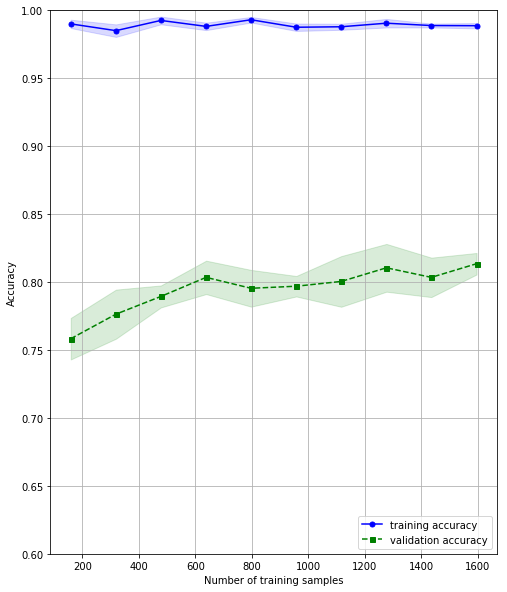

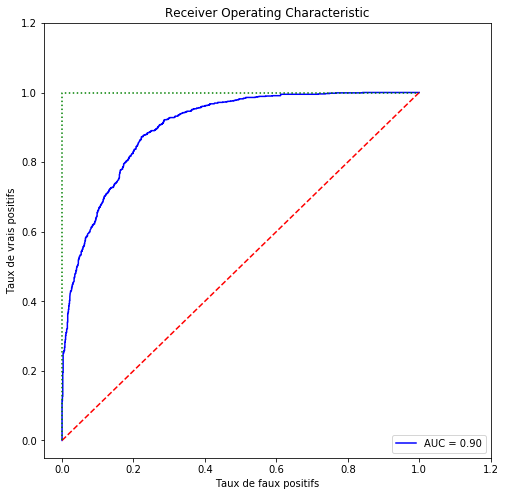

In [46]:
plot_learning_curve(xgb, X_train, y_train)
plot_roc_curve(xgb,X_test,y_test)

In [47]:
print(classification_report(y_test, y_xgb))

              precision    recall  f1-score   support

         0.0       0.85      0.78      0.82      1009
         1.0       0.79      0.86      0.83       985

   micro avg       0.82      0.82      0.82      1994
   macro avg       0.82      0.82      0.82      1994
weighted avg       0.82      0.82      0.82      1994

